<a href="https://colab.research.google.com/github/LaurelleJinelle/Intro-to-ML-Summative/blob/main/Summative__Intro_to_ML_Laurelle_Jinelle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Training And Evaluation - Intro to ML Summative
by Jinelle Nformi

This notebook contains reproducable code cells that demonstrate the application of both traditional and deep learning machine learning approaches, in predicting a students academic performance based on a number of features.

Multiple experiments were careried out to ensure the models trained were optimised to their best capacity.





**Dataset Source** : https://www.kaggle.com/datasets/nabeelqureshitiii/student-performance-dataset

**Research Question** : Do personal and unconventional factors affect students’ final grades as much as traditional academic assessments like assignments and projects?

##Library imports and Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, RocCurveDisplay, classification_report,
)
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

##Data Loading and Preparation

In [ ]:
!gdown --id 1b4h1bR84h-T5o9vNK0HkwutPwmBLy2PX -O student_performance.csv
df = pd.read_csv('student_performance.csv')
df.head(5)


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1b4h1bR84h-T5o9vNK0HkwutPwmBLy2PX
To: /content/student_performance.csv
100% 28.0M/28.0M [00:00<00:00, 83.2MB/s]


,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score,grade
0,1,18.5,95.6,3.8,97.9,A
1,2,14.0,80.0,2.5,83.9,B
2,3,19.5,86.3,5.3,100.0,A
3,4,25.7,70.2,7.0,100.0,A
4,5,13.4,81.9,6.9,92.0,A


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   student_id               1000000 non-null  int64  
 1   weekly_self_study_hours  1000000 non-null  float64
 2   attendance_percentage    1000000 non-null  float64
 3   class_participation      1000000 non-null  float64
 4   total_score              1000000 non-null  float64
 5   grade                    1000000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 45.8+ MB


From here, we can see that the 'grade' column has the object datatype. We need to convert it to a numerical column.

In [ ]:
df['grade'].value_counts()

,count
grade,
A,548644
B,258174
C,141980
D,44998
F,6204


Based on the output from this code cell, I can see that the 'grade' column contains categorical data. We would use LabelEncoder to convert this data into numeric data.
We can also see that the data is imbalanced. We would handle this later in the training process

In [ ]:
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])

In [ ]:
df['grade'].value_counts()

,count
grade,
0,548644
1,258174
2,141980
3,44998
4,6204


Data has been converted successfully!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   student_id               1000000 non-null  int64  
 1   weekly_self_study_hours  1000000 non-null  float64
 2   attendance_percentage    1000000 non-null  float64
 3   class_participation      1000000 non-null  float64
 4   total_score              1000000 non-null  float64
 5   grade                    1000000 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 45.8 MB


###Data Visualization

Plotting a correlation heatmap with the target column helps us to understandd which columns to drop based on the level of correlation they have with the target column

We do this so we can be sure that the columns being drooped are supposed to be dropped, and the ones left are actually useful to the training process

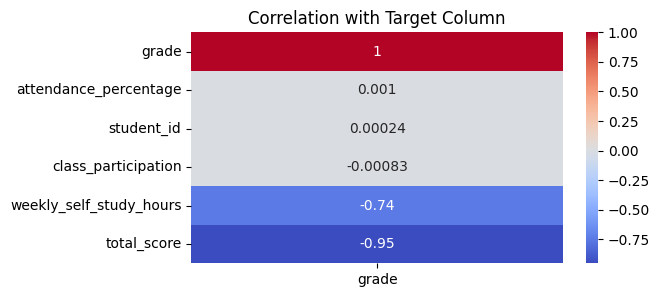

In [ ]:
target_corr = df.corr()['grade'].sort_values(ascending=False)
plt.figure(figsize=(6, len(df.columns)/2))
sns.heatmap(target_corr.to_frame(), annot=True, cmap="coolwarm")
plt.title("Correlation with Target Column")
plt.show()

Based on the corrrelation, 'attendance_percentage', 'class_participation' and 'student_id' all have really low correlation to the target column, and therefore are safe to drop.

However, this would leave just two columns for the model to train with. This is often not ideal.

To fix this problem, we would do Featue Engineering, and create new columns with the existing columns.

In [ ]:
df['study_hours_squared'] = df['weekly_self_study_hours'] ** 2
df['study_hours_log'] = np.log1p(df['weekly_self_study_hours'])
df['study_hours_x_attendance'] = df['weekly_self_study_hours'] * df['attendance_percentage']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   student_id                1000000 non-null  int64  
 1   weekly_self_study_hours   1000000 non-null  float64
 2   attendance_percentage     1000000 non-null  float64
 3   class_participation       1000000 non-null  float64
 4   total_score               1000000 non-null  float64
 5   grade                     1000000 non-null  int64  
 6   study_hours_squared       1000000 non-null  float64
 7   study_hours_log           1000000 non-null  float64
 8   study_hours_x_attendance  1000000 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 68.7 MB


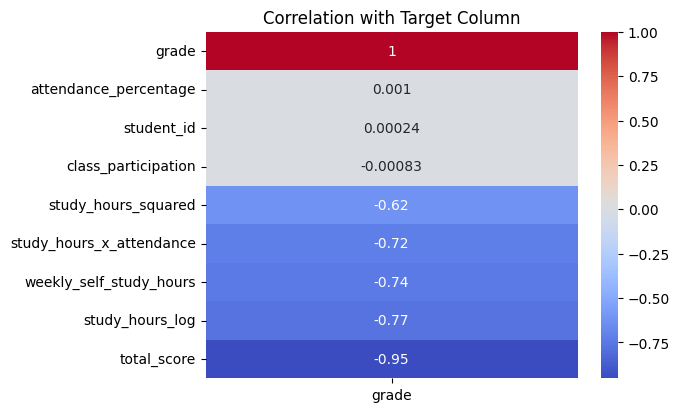

In [ ]:
target_corr = df.corr()['grade'].sort_values(ascending=False)
plt.figure(figsize=(6, len(df.columns)/2))
sns.heatmap(target_corr.to_frame(), annot=True, cmap="coolwarm")
plt.title("Correlation with Target Column")
plt.show()

The new columns that were added have good correlation with the target column, and would aid the training process since the model now has new patterns to learn.

###Experiment 1

In [ ]:
X = df.drop(["grade", "student_id", "attendance_percentage", "class_participation"], axis=1)
y = df["grade"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: grade
0    438915
1    206539
2    113584
3     35999
4      4963
Name: count, dtype: int64
After SMOTE: grade
0    438915
2    438915
1    438915
3    438915
4    438915
Name: count, dtype: int64


SMOTE was used to tackle the data imbalance problem.

In [ ]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    109729
           1       1.00      1.00      1.00     51635
           2       1.00      1.00      1.00     28396
           3       1.00      1.00      1.00      8999
           4       0.99      0.99      0.99      1241

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000


ROC AUC Score (OvR): 1.0000

=== Confusion Matrix ===


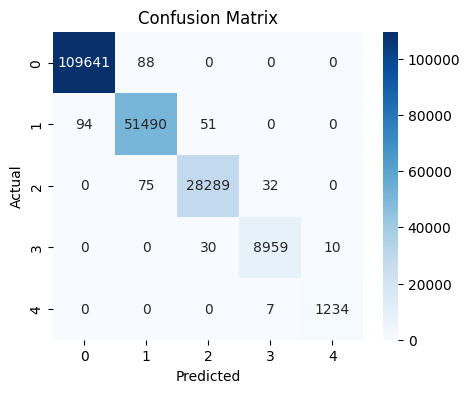

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced_subsample'
)
rf.fit(X_train_res_scaled, y_train_res)

y_pred = rf.predict(X_test_scaled)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

y_proba = rf.predict_proba(X_test_scaled)

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')  # or 'ovo'
print(f"\nROC AUC Score (OvR): {roc_auc:.4f}")

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

From the results from this experiment, the model is too perfect and is not realistic. This tells me that there is data leakegae somewhere.


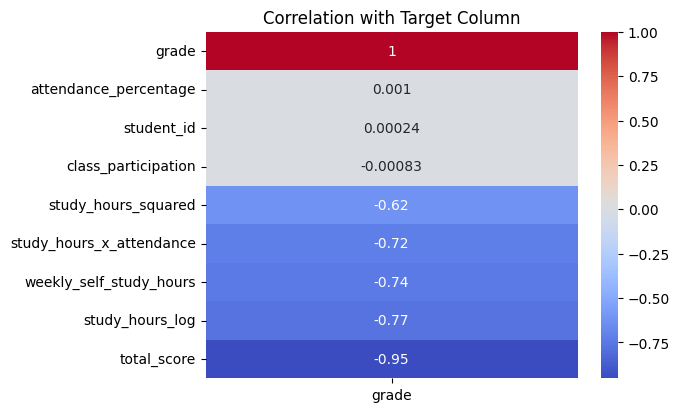

In [ ]:
target_corr = df.corr()['grade'].sort_values(ascending=False)
plt.figure(figsize=(6, len(df.columns)/2))
sns.heatmap(target_corr.to_frame(), annot=True, cmap="coolwarm")
plt.title("Correlation with Target Column")
plt.show()

Looking at the correlation values, we can see that 'total_score' has a really high negative correlation value, which means that this is probably the column causing the data leakage.
This means that the model is basically cheating and replicating the results from the 'total_score' column, it is not learning anything.
To fix this and stop the data leakage, we would also drop the 'total_score' column.

###Experiment 2

In [ ]:
X = df.drop(["grade", "student_id", "attendance_percentage", "class_participation", "total_score"], axis=1)
y = df["grade"]

'total_score' dropped!

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   weekly_self_study_hours   1000000 non-null  float64
 1   study_hours_squared       1000000 non-null  float64
 2   study_hours_log           1000000 non-null  float64
 3   study_hours_x_attendance  1000000 non-null  float64
dtypes: float64(4)
memory usage: 30.5 MB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: grade
0    438915
1    206539
2    113584
3     35999
4      4963
Name: count, dtype: int64
After SMOTE: grade
0    438915
2    438915
1    438915
3    438915
4    438915
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.77      0.82    109729
           1       0.47      0.55      0.51     51635
           2       0.43      0.46      0.44     28396
           3       0.32      0.39      0.35      8999
           4       0.14      0.49      0.22      1241

    accuracy                           0.65    200000
   macro avg       0.45      0.53      0.47    200000
weighted avg       0.69      0.65      0.66    200000


ROC AUC Score (OvR): 0.8835

=== Confusion Matrix ===


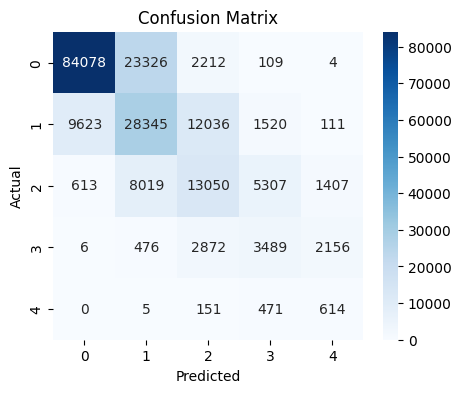

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res_scaled, y_train_res)

y_pred = rf.predict(X_test_scaled)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

y_proba = rf.predict_proba(X_test_scaled)

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"\nROC AUC Score (OvR): {roc_auc:.4f}")

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

####Result Analysis
Model has an accuracy os 65%, which means that it predicts 65% of the samples correctly
ROC AUV Score = 0.8835; this shows that the model differentiates between classes fairly well in terms of probabilities.
Minority classes 3 and 4 have weak precision but a decent recall. This is as a result of using SMOTE; the model learns to catch minority instances but sometimes misclassifies others as minority in the process



The drop from nearly perfect scores to more realistic ones is something to expect after removing leakage.
The model now shows difficulty in oredicting the minority classes without the leaked features.
This tells us that class imbalance is definitely affecting the performace of the model

###Experiment 3

Running RandomizedSearchCV on 20% sample...
Fitting 2 folds for each of 5 candidates, totalling 10 fits

Best Parameters Found:
{'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 53}

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.76      0.82    109729
           1       0.47      0.55      0.51     51635
           2       0.43      0.46      0.45     28396
           3       0.32      0.39      0.36      8999
           4       0.14      0.50      0.22      1241

    accuracy                           0.65    200000
   macro avg       0.45      0.53      0.47    200000
weighted avg       0.69      0.65      0.66    200000


ROC AUC Score (OvR): 0.8848

=== Confusion Matrix ===


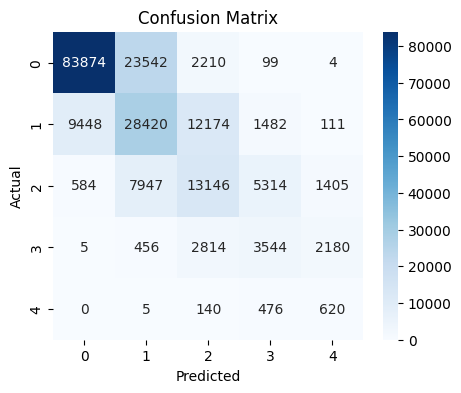

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# === Subsample for tuning (20%)===
X_tune, _, y_tune, _ = train_test_split(
    X_train_res_scaled, y_train_res,
    train_size=0.2, random_state=42, stratify=y_train_res
)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': randint(30, 100),
    'max_depth': [10, 15, 20],
    'min_samples_split': randint(2, 8),
    'min_samples_leaf': randint(1, 3),
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,
    scoring='f1_weighted',
    cv=2,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Running RandomizedSearchCV on 20% sample...")
random_search.fit(X_tune, y_tune)

print("\nBest Parameters Found:")
print(random_search.best_params_)


best_params = random_search.best_params_.copy()
best_params['n_estimators'] = 300

best_rf = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_res_scaled, y_train_res)


y_pred = best_rf.predict(X_test_scaled)
y_proba = best_rf.predict_proba(X_test_scaled)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"\nROC AUC Score (OvR): {roc_auc:.4f}")


print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


####Result Analysis
Model did not improve significantly with the new hyperparameters
We would move on to a new model to see if the metrics would improve

###Experiment 4

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:26:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.76      0.82    109729
           1       0.47      0.55      0.51     51635
           2       0.42      0.42      0.42     28396
           3       0.28      0.37      0.32      8999
           4       0.12      0.67      0.21      1241

    accuracy                           0.64    200000
   macro avg       0.44      0.55      0.45    200000
weighted avg       0.69      0.64      0.66    200000

ROC AUC Score (OvR): 0.8824


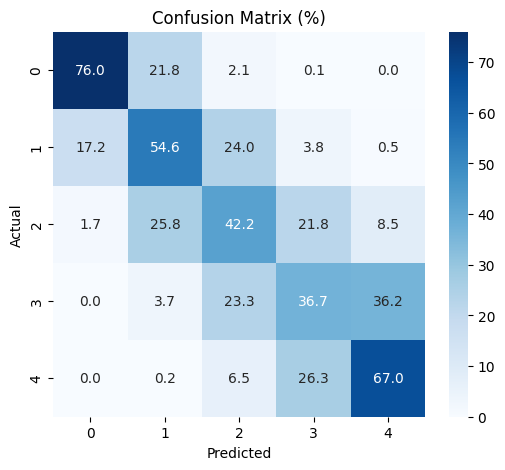

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(y_train.unique()),
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.6,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_res_scaled, y_train_res)


y_pred = xgb_model.predict(X_test_scaled)
y_proba = xgb_model.predict_proba(X_test_scaled)


print("=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"ROC AUC Score (OvR): {roc_auc:.4f}")


cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

####Result Analysis
The models are still not improving even after changing the model
However, the strenghts of this modelinclude the high ROC AUC, which means that the model is good at making predictions based on probability, and the weakness is that the minority class has poor precision which means the data needs to be handled better.

Our way forward is to finetune the hyperparameters and adjust the thresholds to improve the f1 score

###Experiment 5

=== XGBoost Classification Report (Threshold Adjusted) ===
              precision    recall  f1-score   support

           0       0.88      0.80      0.84    109729
           1       0.49      0.66      0.56     51635
           2       0.51      0.37      0.43     28396
           3       0.44      0.51      0.48      8999
           4       0.00      0.00      0.00      1241

    accuracy                           0.68    200000
   macro avg       0.46      0.47      0.46    200000
weighted avg       0.70      0.68      0.69    200000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC AUC Score (OvR): 0.8826


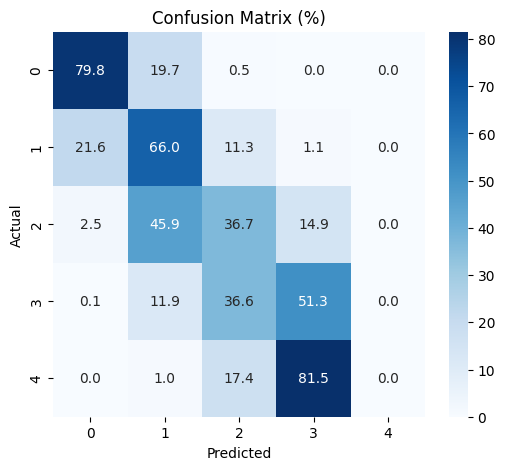

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(y_train.unique()),
    n_estimators=1200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    min_child_weight=3,
    tree_method='hist',
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train_res_scaled, y_train_res)

y_proba = xgb_model.predict_proba(X_test_scaled)

thresholds = [0.4, 0.25, 0.25, 0.2, 0.15]
y_pred_adjusted = np.array([np.argmax(p >= thresholds) if any(p >= thresholds) else np.argmax(p)
                            for p in y_proba])

print("=== XGBoost Classification Report (Threshold Adjusted) ===")
print(classification_report(y_test, y_pred_adjusted))

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"ROC AUC Score (OvR): {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred_adjusted)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

####Result Analysis
Accuracy is slightly higher than before, 68%, and ROC AUC is still similar to how it was before
The major difference is that the adjustment of the thresholds greatly affected the metrics of the individual classes.
However, the threshold adjustment helped the middle frequency classes (1-3), but class 4 is completely missing

###Experiment 6

=== XGBoost Classification Report (Threshold Adjusted) ===
              precision    recall  f1-score   support

           0       0.93      0.66      0.78    109729
           1       0.43      0.62      0.51     51635
           2       0.40      0.37      0.38     28396
           3       0.23      0.35      0.28      8999
           4       0.11      0.74      0.19      1241

    accuracy                           0.60    200000
   macro avg       0.42      0.55      0.43    200000
weighted avg       0.69      0.60      0.62    200000

ROC AUC Score (OvR): 0.8825


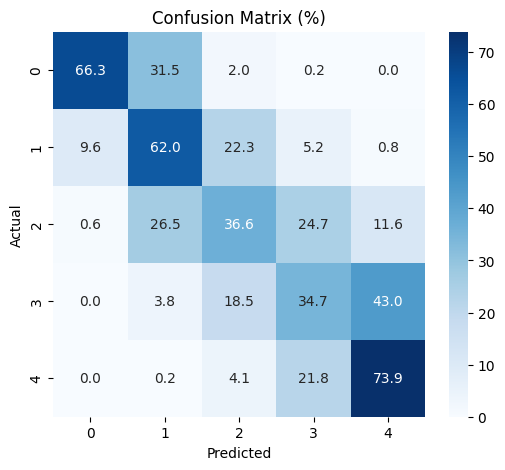

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(y_train.unique()),
    n_estimators=1200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    min_child_weight=3,
    tree_method='hist',
    eval_metric='mlogloss',
    random_state=42
)


xgb_model.fit(X_train_res_scaled, y_train_res)


y_proba = xgb_model.predict_proba(X_test_scaled)

thresholds = [0.4, 0.25, 0.25, 0.2, 0.15]
adjusted_proba = y_proba / thresholds
y_pred_adjusted = np.argmax(adjusted_proba, axis=1)


print("=== XGBoost Classification Report (Threshold Adjusted) ===")
print(classification_report(y_test, y_pred_adjusted))

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"ROC AUC Score (OvR): {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred_adjusted)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

####Result Analysis

Applying per-class threshold adjustments in XGBoost improved recall for minority classes (particularly class 4, from 0.67 to 0.74) but slightly reduced overall accuracy (0.64 → 0.60) and precision in dominant classes.
The ROC-AUC remained constant (~0.882), indicating that the model’s ranking ability did not chnage.
These results confirm that threshold optimization can effectively rebalance model sensitivity toward underrepresented classes but introduces a trade-off between precision and recall.

###Experiment 7

Because none of our classical ML models were able to significantly improve, i think it is wise to use a neural network.

This is a Lightweight MLP that we would use a simple architectiure.
The code is a simple feed forward neural network that was built using TensorFlow/Keras, with a design for multiclass classification

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

Epoch 1/10
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.5714 - loss: 0.9609 - val_accuracy: 0.0000e+00 - val_loss: 1.5396
Epoch 2/10
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.5786 - loss: 0.9337 - val_accuracy: 0.0000e+00 - val_loss: 1.5918
Epoch 3/10
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5790 - loss: 0.9326 - val_accuracy: 0.0000e+00 - val_loss: 1.6270
Epoch 4/10
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5788 - loss: 0.9328 - val_accuracy: 0.0000e+00 - val_loss: 1.6505
Epoch 5/10
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5791 - loss: 0.9323 - val_accuracy: 0.0000e+00 - val_loss: 1.6901
Epoch 6/10
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.5791 - loss: 0.9321 - val_accuracy: 0.0000e+00 - val_loss: 1.6596


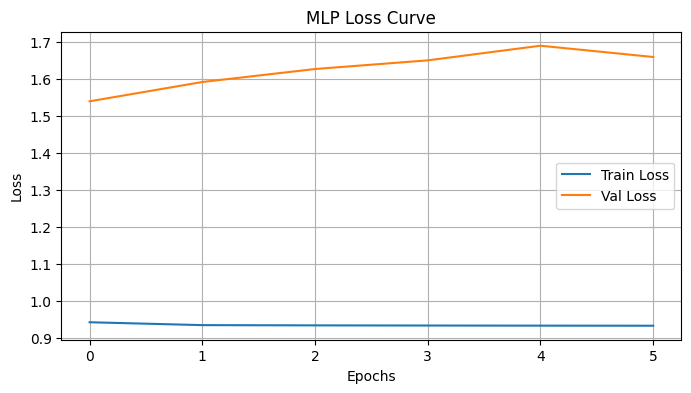

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Overall Model Metrics ===
Accuracy : 0.6563
Precision: 0.6936
Recall   : 0.6563
F1 Score : 0.6670
ROC AUC  : 0.8909


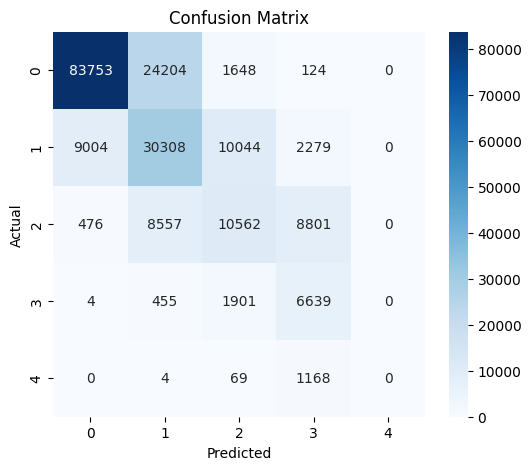

In [ ]:
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
except:
    pass

n_features = X_train_res_scaled.shape[1]
n_classes = len(np.unique(y_train_res))

mlp = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(n_classes, activation='softmax', dtype='float32')
])

mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mlp.fit(
    X_train_res_scaled, y_train_res,
    validation_split=0.15,
    epochs=10,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MLP Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred_proba = mlp.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print("\n=== Overall Model Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

####Results Analysis

The neural network consisted of two hidden layers (128 and 64 neurons) with ReLU activations, batch normalization, and dropout regularization to prevent overfitting.

* The accuracy of ~65.6% suggests that the model correctly classified about two-thirds of the test samples.

* The precision (0.6936) and recall (0.6563) are closely aligned, showing balanced performance across classes.

* The F1-score (0.6670) further supports that the model maintains a reasonable trade-off between precision and recall.

* The ROC AUC score (0.8909) indicates strong discriminative capability — even though accuracy is moderate, the model is good at ranking positive classes higher than negatives overall.

* Training loss remained relatively low and stable (~0.93) across epochs.

* Validation loss, however, increased gradually from ~1.54 to ~1.69, indicating potential overfitting — the model was learning the training data well but struggling to generalize to unseen validation samples.

* The early stopping mechanism prevented unnecessary epochs once validation performance stopped improving.

Overall, this model has good class seperation with high AUC, but moderate accuracy

Class weights: {0: np.float64(1.000001608247091), 1: np.float64(0.9999989278381465), 2: np.float64(0.9999989278381465), 3: np.float64(1.000001608247091), 4: np.float64(0.9999989278381465)}
Epoch 1/20
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.5536 - loss: 0.9960 - val_accuracy: 0.5631 - val_loss: 0.9602 - learning_rate: 0.0010
Epoch 2/20
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 143s 12ms/step - accuracy: 0.5599 - loss: 0.9654 - val_accuracy: 0.5617 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 3/20
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - accuracy: 0.5601 - loss: 0.9646 - val_accuracy: 0.5617 - val_loss: 0.9592 - learning_rate: 0.0010
Epoch 4/20
7287/7287 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - accuracy: 0.5597 - loss: 0.9641 - val_accuracy: 0.5628 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 5/20
7283/7287 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5596 - loss: 0.9639
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
7287/7287 ━━━━━━━━━━━

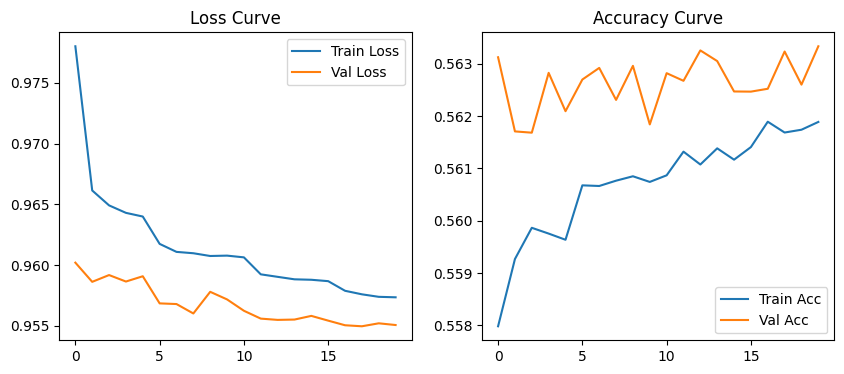

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

=== Overall Model Metrics ===
Accuracy : 0.6359
Precision: 0.6870
Recall   : 0.6359
F1 Score : 0.6555
ROC AUC  : 0.8823


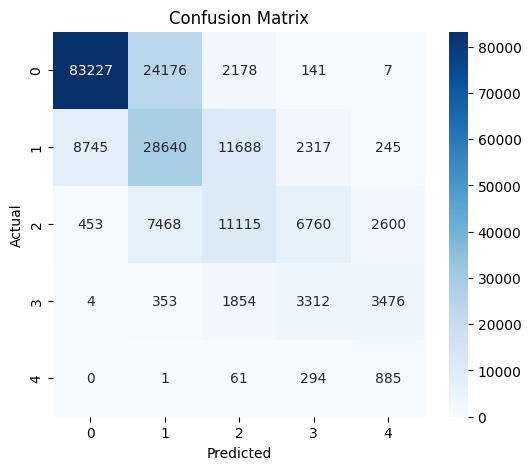

In [ ]:
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight

try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
except:
    pass

X_train_bal, X_val_bal, y_train_bal, y_val_bal = train_test_split(
    X_train_res_scaled, y_train_res,
    test_size=0.15,
    random_state=42,
    stratify=y_train_res
)

n_features = X_train_bal.shape[1]
n_classes = len(np.unique(y_train_bal))

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_bal),
    y=y_train_bal
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

mlp = models.Sequential([
    layers.Input(shape=(n_features,)),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.35),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.35),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),

    layers.Dense(n_classes, activation='softmax', dtype='float32')
])

mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

history = mlp.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_val_bal, y_val_bal),
    epochs=20,
    batch_size=256,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

y_pred_proba = mlp.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print("\n=== Overall Model Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

####Result Analysis

From the previous model, these were the improvemnets made
* More hidden layers to create a more complex model
* Weight regularization and increased dropout rate combat overfitting
* Class imbalance handled with class_weight
* Slightly higher learning rate for faster training

We see that this fine-tuned model is not learning much despite the many epochs
The model is underfitting
* Loss barely decreases
* Accuracy is stuck at 56%; this tells me that the model cannot see deeper patterns
* Confusion matrix still showd bias towards the first two classes despite using compute_class_weight
* AUC tells me that the model ranks predictions well but the decision thresholds are the problem

Ways to fix this might inclde adding more layers to increase the capacity of the model.

In [1]:
data = [
    # Random Forests
    ["Random Forest #1",
     "n_estimators=200, class_weight='balanced_subsample', random_state=42",
     1.00, 1.00, 1.00, 1.00, 1.0000,
     "Initial run (data leakage) — perfect but invalid results"],

    ["Random Forest #2",
     "n_estimators=300, max_depth=20, random_state=42, n_jobs=-1",
     0.65, 0.69, 0.65, 0.66, 0.8835,
     "After data leakage fix — realistic performance"],

    ["Random Forest #3 (RandomizedSearchCV)",
     "n_estimators=300, max_depth≈15, min_samples_split≈4, "
     "min_samples_leaf≈2, max_features='sqrt', class_weight='balanced'",
     0.65, 0.69, 0.65, 0.67, 0.8848,
     "Tuned RF — slight improvement over RF#2"],

    # XGBoost
    ["XGBoost #1",
     "n_estimators=500, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6",
     0.64, 0.69, 0.64, 0.66, 0.8824,
     "Baseline XGBoost model"],

    ["XGBoost #2 (Threshold Adjusted 1)",
     "n_estimators=1200, max_depth=5, learning_rate=0.05, subsample=0.8, "
     "colsample_bytree=0.7, gamma=0.1, min_child_weight=3, tree_method='hist'",
     0.68, 0.70, 0.68, 0.69, 0.8826,
     "Improved recall after threshold tuning (class 4 underpredicted)"],

    ["XGBoost #3 (Threshold Adjusted 2)",
     "Same as above, but with adjusted_proba = y_proba / thresholds",
     0.60, 0.69, 0.60, 0.62, 0.8825,
     "Alternate thresholding — lower accuracy"],

    # MLPs
    ["MLP #1",
     "Hidden Layers = [128, 64], Dropout(0.25), BatchNorm, Adam(lr=5e-4), epochs=10, batch=256",
     0.6563, 0.6936, 0.6563, 0.6670, 0.8909,
     "Baseline MLP — best overall balance"],

    ["MLP #2 (Regularized)",
     "Hidden Layers = [256, 128, 64], Dropout(0.35), L2(1e-4), Adam(lr=1e-3), class weights, "
     "ReduceLROnPlateau, epochs=20",
     0.6359, 0.6870, 0.6359, 0.6555, 0.8823,
     "Regularized MLP — slightly lower accuracy, better generalization"]
]

columns = ["Model", "Hyperparameters", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Notes"]
results_df = pd.DataFrame(data, columns=columns)

pd.set_option('display.max_colwidth', None)
results_df.style.set_caption("Model Performance Comparison")

results_df

,Model,Hyperparameters,Accuracy,Precision,Recall,F1 Score,ROC AUC,Notes
0,Random Forest #1,"n_estimators=200, class_weight='balanced_subsample', random_state=42",1.0000,1.0000,1.0000,1.0000,1.0000,Initial run (data leakage) — perfect but invalid results
1,Random Forest #2,"n_estimators=300, max_depth=20, random_state=42, n_jobs=-1",0.6500,0.6900,0.6500,0.6600,0.8835,After data leakage fix — realistic performance
2,Random Forest #3 (RandomizedSearchCV),"n_estimators=300, max_depth≈15, min_samples_split≈4, min_samples_leaf≈2, max_features='sqrt', class_weight='balanced'",0.6500,0.6900,0.6500,0.6700,0.8848,Tuned RF — slight improvement over RF#2
3,XGBoost #1,"n_estimators=500, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6",0.6400,0.6900,0.6400,0.6600,0.8824,Baseline XGBoost model
4,XGBoost #2 (Threshold Adjusted 1),"n_estimators=1200, max_depth=5, learning_rate=0.05, subsample=0.8, colsample_bytree=0.7, gamma=0.1, min_child_weight=3, tree_method='hist'",0.6800,0.7000,0.6800,0.6900,0.8826,Improved recall after threshold tuning (class 4 underpredicted)
5,XGBoost #3 (Threshold Adjusted 2),"Same as above, but with adjusted_proba = y_proba / thresholds",0.6000,0.6900,0.6000,0.6200,0.8825,Alternate thresholding — lower accuracy
6,MLP #1,"Hidden Layers = [128, 64], Dropout(0.25), BatchNorm, Adam(lr=5e-4), epochs=10, batch=256",0.6563,0.6936,0.6563,0.6670,0.8909,Baseline MLP — best overall balance
7,MLP #2 (Regularized),"Hidden Layers = [256, 128, 64], Dropout(0.35), L2(1e-4), Adam(lr=1e-3), class weights, ReduceLROnPlateau, epochs=20",0.6359,0.6870,0.6359,0.6555,0.8823,"Regularized MLP — slightly lower accuracy, better generalization"
